好きな用途に利用できるnotebookです。  
データの可視化や簡単なモデルの構築などにご利用下さい。

## 必要なライブラリのimport

In [1]:
import warnings
import time
import sys
import datetime
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# dfの確認　自作関数
def data_confirm(df):
  print(df.head())
  print('カラム名:\n',df.columns)
  print('行数・列数:\n',df.shape)
  print('列ごと欠損値の数:\n', df.isnull().sum())
  print('データの型:\n', df.info())
  print('重複:\n',df.duplicated().sum())
  print('ユニーク数:\n', df.nunique())
  print('基本統計量:\n', df.describe())
  print()

## データの読み込み

In [36]:
os.getcwd()

'c:\\Users\\kakeru.oshikiri.bt\\研修\\kaggle\\AnalyticalPipeline\\work\\oshikiri\\notebooks'

In [4]:
new = pd.read_csv('../../../../data/raw/new_merchant_transactions.csv',parse_dates=['purchase_date'])

hist = pd.read_csv('../../../../data/raw/historical_transactions.csv',parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(hist)
new_transactions = binarize(new)

In [5]:
# データの読み込み
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (pd.Timestamp('2018-02-01') - df['first_active_month']).dt.days
    return df

train = read_data('../../../../data/raw/train.csv')
test = read_data('../../../../data/raw/test.csv')

target = train['target']
#del train['target']

In [99]:
data_confirm(train)

  first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

     target  elapsed_time  
0 -0.820283           245  
1  0.392913           396  
2  0.688056           549  
3  0.142495           153  
4 -0.159749            92  
カラム名:
 Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target', 'elapsed_time'],
      dtype='object')
行数・列数:
 (201917, 7)
列ごと欠損値の数:
 first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
elapsed_time          0
dtype: int64
<class 'pandas.core.frame.DataFra

In [100]:
data_confirm(test)

  first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-04-01  C_ID_0ab67a22ab          3          3          1   
1         2017-01-01  C_ID_130fd0cbdd          2          3          0   
2         2017-08-01  C_ID_b709037bc5          5          1          1   
3         2017-12-01  C_ID_d27d835a9f          2          1          0   
4         2015-12-01  C_ID_2b5e3df5c2          5          1          1   

   elapsed_time  
0         306.0  
1         396.0  
2         184.0  
3          62.0  
4         793.0  
カラム名:
 Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'elapsed_time'],
      dtype='object')
行数・列数:
 (123623, 6)
列ごと欠損値の数:
 first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
elapsed_time          1
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 6 columns):
 #   Column      

In [109]:
data_confirm(hist)

   authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_4e6213e9bc       88           0             0   
1                1  C_ID_4e6213e9bc       88           0             0   
2                1  C_ID_4e6213e9bc       88           0             0   
3                1  C_ID_4e6213e9bc       88           0             0   
4                1  C_ID_4e6213e9bc       88           0             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  
0        -0.703331 2017-06-25 15:33:07         1.0        16            37  
1   

In [108]:
data_confirm(new)

   authorized_flag          card_id  city_id  category_1  installments  \
0                1  C_ID_415bb3a509      107           0             1   
1                1  C_ID_415bb3a509      140           0             1   
2                1  C_ID_415bb3a509      330           0             1   
3                1  C_ID_415bb3a509       -1           1             1   
4                1  C_ID_ef55cf8d4b       -1           1             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   307  M_ID_b0c793002c          1   
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  
0        -0.557574 2018-03-11 14:57:36         1.0         9            19  
1   

In [57]:
card_id = {"train":train['card_id'].unique(),
            "test":test['card_id'].unique()}
card_id["common"] = set(card_id['train']) & set(card_id['test'])
print(card_id['common'])

card_id['total'] = hist['card_id'].unique()
print(len(set(card_id['test']) & set(card_id['total'])))

print(len(card_id['test']))

print(len(set(card_id['train']) & set(card_id['total'])))

print(len(card_id['train']))

# print(new_transactions.card_id.nunique(),
#       historical_transactions.card_id.nunique(),
#       train.card_id.nunique(),
#       test.card_id.nunique(),

# )
card_id

set()
123623
123623
201917
201917


{'train': array(['C_ID_92a2005557', 'C_ID_3d0044924f', 'C_ID_d639edf6cd', ...,
        'C_ID_7666735b3d', 'C_ID_73f5a0efd0', 'C_ID_92c9984c58'],
       dtype=object),
 'test': array(['C_ID_0ab67a22ab', 'C_ID_130fd0cbdd', 'C_ID_b709037bc5', ...,
        'C_ID_21d56d950c', 'C_ID_6c46fc5a9d', 'C_ID_87e7979a5f'],
       dtype=object),
 'common': set(),
 'total': array(['C_ID_4e6213e9bc', 'C_ID_5037ff576e', 'C_ID_0e171c1b48', ...,
        'C_ID_e49b1996b0', 'C_ID_2863d2fa95', 'C_ID_5c240d6e3c'],
       dtype=object)}

In [58]:
card_id['new'] = new['card_id'].unique()
print(len(card_id['new']))
print(len(set(card_id['test']) & set(card_id['new'])))
print(len(set(card_id['train']) & set(card_id['new'])))

290001
110015
179986


In [91]:
hist.groupby('category_3',as_index=False,dropna=False).agg({'card_id':'count'})

,category_3,card_id
0,A,15411747
1,B,11677522
2,C,1844933
3,NaN,178159


In [92]:
hist.card_id.nunique()

325540

In [95]:
train[train.card_id.isin(hist.card_id)]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92
...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,153
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,854
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,184
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,580


(array([2.207e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

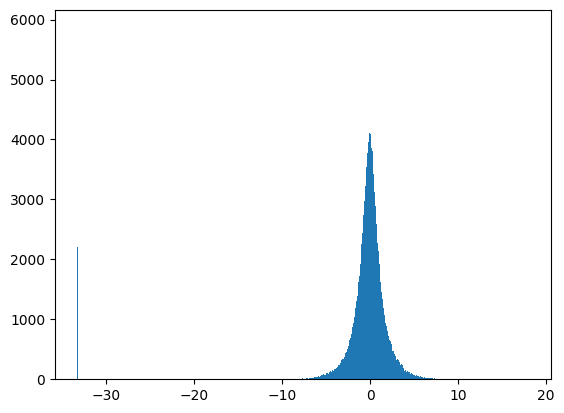

In [49]:
plt.hist(train.target,bins='auto')

In [84]:
print(len(train.query('target<-30')),
      len(train),
      len(train.query('target<-30'))/len(train),)

2207 201917 0.010930233709890698


(array([3.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 4.000e+00, 4.000e+00,
        1.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 4.000e+00,
        4.000e+00, 4.000e+00, 4.000e+00, 1.000e+01, 4.000e+00, 1.000e+01,
        4.000e+00, 5.000e+00, 2.000e+00, 7.000e+00, 6.000e+00, 1.100e+01,
        1.000e+01, 1.100e+01, 6.000e+00, 4.000e+00, 7.000e+00, 1.900e+01,
        1.500e+01, 3.000e+00, 7.000e+00, 1.200e+01, 1.100e+01, 7.000e+00,
        7.000e+00, 1.700e+01, 1.400e+01, 1.700e+01, 2.000e+01, 9.000e+00,
        1.800e+01, 2.000e+01, 1.200e+01, 2.100e+01, 2.000e+01, 2.000e+01,
        1.500e+01, 2.600e+01, 2.600e+01, 3.600e+01, 2.600e+01, 2.900e+01,
        3.000e+01, 3.000e+01, 2.800e+01, 2.400e+01, 4.000e+01, 3.700e+01,
        3.100e+01, 4.600e+01, 4.900e+01, 4.600e+01, 4.200e+01, 4.800e+01,
        4.400e+01, 6.100e+01, 5.900e+0

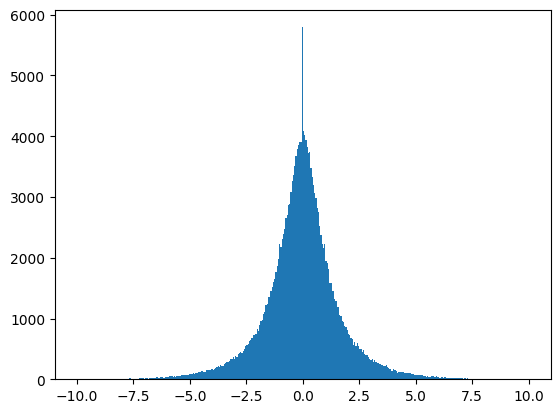

In [48]:
plt.hist(train.query('-10 < target < 10').target,bins='auto')#bins=range(-10,11,1))

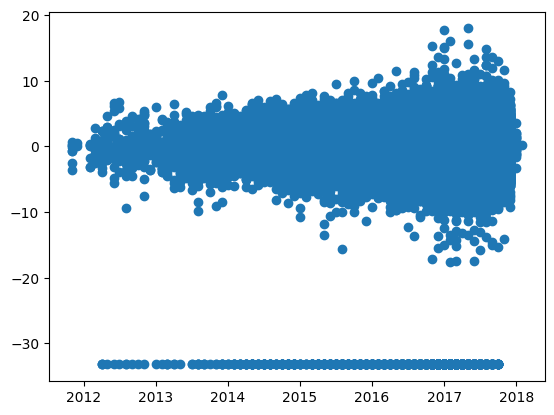

In [155]:
plt.scatter(train.first_active_month, train.target)

In [86]:
df = hist[['card_id','authorized_flag']].groupby(['card_id','authorized_flag']).agg(count=('card_id','count')).reset_index()

# カードIDごとの合計を計算
total_counts = df.groupby('card_id')['count'].sum().reset_index()
total_counts = total_counts.rename(columns={'count': 'total_count'})

# 元のデータと合計を結合
df = df.merge(total_counts, on='card_id')

# 割合を計算
df['ratio'] = df['count'] / df['total_count']
print(df)
# 結果を整形
result = df.pivot(index='card_id', columns='authorized_flag', values=['ratio','count']).reset_index().rename(columns={0: 'No', 1: 'Yes'})

result

           card_id       authorized_flag  count  total_count    ratio 
0       C_ID_00007093c1         0           35       149      0.234899
1       C_ID_00007093c1         1          114       149      0.765101
2       C_ID_0001238066         0            3       123      0.024390
3       C_ID_0001238066         1          120       123      0.975610
4       C_ID_0001506ef0         0            4        66      0.060606
...                 ...              ...    ...          ...       ...
601236  C_ID_ffff756266         1           14        24      0.583333
601237  C_ID_ffff828181         0           24       190      0.126316
601238  C_ID_ffff828181         1          166       190      0.873684
601239  C_ID_fffffd5772         0            9        84      0.107143
601240  C_ID_fffffd5772         1           75        84      0.892857

[601241 rows x 5 columns]


card_id        ratio             count       
authorized_flag                      No       Yes      No   Yes  
0                C_ID_00007093c1  0.234899  0.765101  35.0  114.0
1                C_ID_0001238066  0.024390  0.975610   3.0  120.0
2                C_ID_0001506ef0  0.060606  0.939394   4.0   62.0
3                C_ID_0001793786  0.125000  0.875000  27.0  189.0
4                C_ID_000183fdda  0.048611  0.951389   7.0  137.0
...                          ...       ...       ...   ...    ...
325535           C_ID_ffff1d9928  0.250000  0.750000   3.0    9.0
325536           C_ID_ffff579d3a  0.131579  0.868421  15.0   99.0
325537           C_ID_ffff756266  0.416667  0.583333  10.0   14.0
325538           C_ID_ffff828181  0.126316  0.873684  24.0  166.0
325539           C_ID_fffffd5772  0.107143  0.892857   9.0   75.0

[325540 rows x 5 columns]

In [87]:
result.columns = ['_'.join(col).strip() for col in result.columns.values]
result

,card_id_,ratio_No,ratio_Yes,count_No,count_Yes
0,C_ID_00007093c1,0.234899,0.765101,35.0,114.0
1,C_ID_0001238066,0.024390,0.975610,3.0,120.0
2,C_ID_0001506ef0,0.060606,0.939394,4.0,62.0
3,C_ID_0001793786,0.125000,0.875000,27.0,189.0
4,C_ID_000183fdda,0.048611,0.951389,7.0,137.0
...,...,...,...,...,...
325535,C_ID_ffff1d9928,0.250000,0.750000,3.0,9.0
325536,C_ID_ffff579d3a,0.131579,0.868421,15.0,99.0
325537,C_ID_ffff756266,0.416667,0.583333,10.0,14.0
325538,C_ID_ffff828181,0.126316,0.873684,24.0,166.0


In [79]:
test.merge(result,on='card_id')

MergeError: Not allowed to merge between different levels. (1 levels on the left, 2 on the right)

In [140]:
result.describe()

authorized_flag,ratio_0,ratio_1
count,275701.000000,325540.000000
mean,0.126078,0.893224
std,0.114190,0.114473
min,0.001082,0.030488
25%,0.047619,0.852941
50%,0.090909,0.926829
75%,0.166667,0.972603
max,0.969512,1.000000


Text(0, 0.5, 'target [loyalty score]')

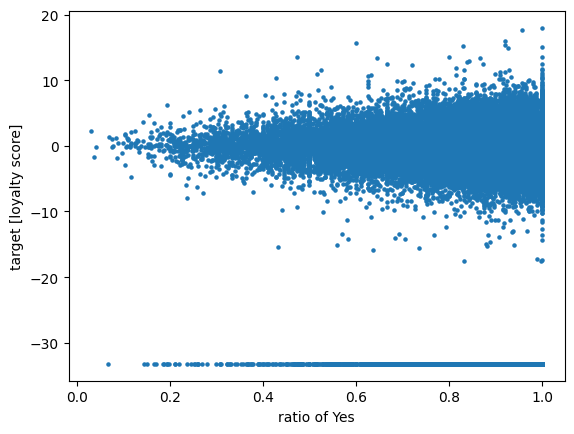

In [139]:
autho_rate= pd.merge(result, train[['card_id','target']])
plt.scatter(autho_rate.ratio_1, autho_rate.target,s=5)
plt.xlabel('ratio of Yes')
plt.ylabel('target [loyalty score]')

(array([5.59220e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 9.22244e+05, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        8.36178e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 5.47290e+04, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        4.47500e+04, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.48150e+04, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        9.29600e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.03890e+04, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        8.63000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.55

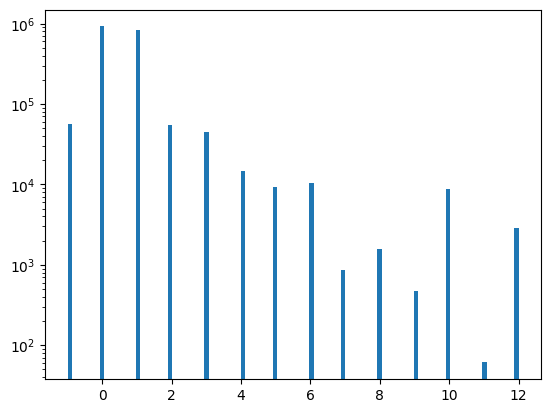

In [144]:
plt.yscale('log')
plt.hist(new.query('installments <100').installments,bins=99)

(array([1.948506e+06, 1.045700e+04, 2.259000e+03, 7.850000e+02,
        3.600000e+02, 2.320000e+02, 1.180000e+02, 9.000000e+01,
        6.000000e+01, 3.600000e+01, 2.800000e+01, 2.300000e+01,
        1.200000e+01, 1.400000e+01, 6.000000e+00, 8.000000e+00,
        2.000000e+00, 4.000000e+00, 2.000000e+00, 5.000000e+00,
        4.000000e+00, 2.000000e+00, 5.000000e+00, 1.000000e+00,
        0.000000e+00, 3.000000e+00, 1.000000e+00, 1.000000e+00,
        3.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

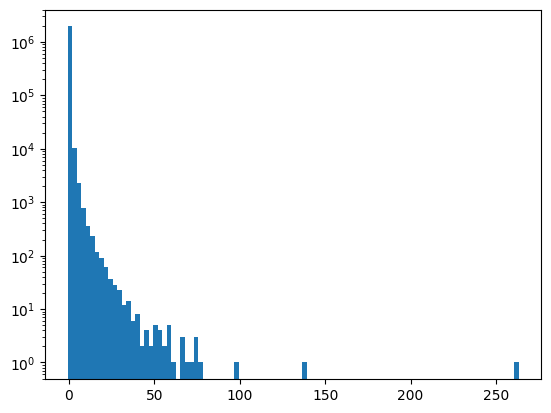

In [147]:
plt.yscale('log')
#plt.hist(new.query(' purchase_amount <1').purchase_amount,bins=100)
plt.hist(new.purchase_amount,bins=100)

In [145]:
new.query(' purchase_amount < 0')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963026,1,C_ID_1320dee851,142,0,0,A,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21
1963027,1,C_ID_f112aa3381,158,0,0,A,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34
1963028,1,C_ID_bd97b86450,69,0,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,1,C_ID_c0513fd84f,130,0,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16


In [150]:
hist.month_lag.unique()

array([ -8,  -7,  -6,  -5, -11,   0,  -3,  -9,  -4,  -1, -13, -10, -12,
        -2], dtype=int64)

In [18]:
historical_transactions.query('card_id == "C_ID_4e6213e9bc"')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1,C_ID_4e6213e9bc,88,0,0,A,278,M_ID_21e1552dab,-10,-0.734135,2017-04-27 13:00:02,1.0,16,37
396,1,C_ID_4e6213e9bc,88,0,0,A,683,M_ID_1449f22bfb,-9,-0.734135,2017-05-03 12:24:35,1.0,16,34
397,1,C_ID_4e6213e9bc,88,0,0,A,278,M_ID_21e1552dab,-9,-0.734887,2017-05-22 12:50:51,1.0,16,37
398,1,C_ID_4e6213e9bc,88,0,0,A,278,M_ID_5e8220e564,-11,-0.740446,2017-03-25 10:10:41,1.0,16,37


In [151]:
new

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963026,1,C_ID_1320dee851,142,0,0,A,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21
1963027,1,C_ID_f112aa3381,158,0,0,A,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34
1963028,1,C_ID_bd97b86450,69,0,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,1,C_ID_c0513fd84f,130,0,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16


In [20]:
merchants = pd.read_csv('../../../../data/raw/merchants.csv',)#parse_dates=['purchase_date'])

In [24]:
merchants

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334691,M_ID_1f4773aa76,1145,705,33,3.174788,-0.047556,N,A,A,1.00,1.022618,3,0.99,1.019505,6,1.00,1.024796,12,Y,69,9,1.0
334692,M_ID_725a60d404,35,544,29,-0.057471,-0.057471,Y,A,A,0.89,0.927684,3,0.78,0.813473,6,0.59,0.606765,12,Y,-1,-1,NaN
334693,M_ID_f2045dd267,35,561,7,-0.057471,-0.057471,N,A,A,0.96,0.982957,3,0.90,0.924769,6,0.74,0.750763,8,Y,160,21,5.0
334694,M_ID_9139332ccc,35,511,7,-0.057471,-0.057471,Y,A,A,0.94,0.919558,3,0.82,0.783000,6,0.65,0.584000,12,Y,-1,-1,NaN


In [166]:
hist.subsector_id.nunique()

41

In [165]:
new.query('state_id < 0')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
3,1,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
14,1,C_ID_ef55cf8d4b,-1,1,1,B,302,M_ID_b9f9332438,1,-0.665539,2018-03-23 21:35:53,NaN,-1,22
21,1,C_ID_ef55cf8d4b,-1,1,3,C,491,M_ID_79692349d6,1,3.009720,2018-03-30 20:05:54,NaN,-1,3
24,1,C_ID_ef55cf8d4b,-1,1,12,C,690,M_ID_3111c6df35,1,2.126146,2018-03-03 11:40:58,NaN,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1962987,1,C_ID_9019c1589a,-1,1,4,C,690,M_ID_3111c6df35,1,-0.680821,2018-02-23 20:23:28,NaN,-1,1
1962998,1,C_ID_a92db7b912,-1,1,1,B,574,M_ID_0855bda176,2,-0.736194,2018-04-03 05:52:30,NaN,-1,22
1963004,1,C_ID_f992de33d6,-1,0,0,A,278,M_ID_9501338459,2,-0.672527,2018-04-28 21:29:42,NaN,-1,37
1963011,1,C_ID_28a5007fc6,-1,1,1,B,661,M_ID_fc7d7969c3,2,-0.745405,2018-04-10 13:55:42,NaN,-1,8


In [12]:
new['merchant_id'].mode()

0    M_ID_00a6ca8a8a
Name: merchant_id, dtype: object

In [11]:
hist['merchant_id'].mode()

0    M_ID_00a6ca8a8a
Name: merchant_id, dtype: object

In [17]:
test[test.first_active_month.isna()]

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
11578,NaT,C_ID_c27b4f80f7,5,2,1,NaN


In [31]:
test.first_active_month.describe()

count                           123622
mean     2017-01-15 21:11:17.762857728
min                2011-11-01 00:00:00
25%                2016-10-01 00:00:00
50%                2017-04-01 00:00:00
75%                2017-09-01 00:00:00
max                2018-01-01 00:00:00
Name: first_active_month, dtype: object

In [32]:
train.first_active_month.mode()

0   2017-09-01
Name: first_active_month, dtype: datetime64[ns]

In [43]:
hist[hist.card_id == "C_ID_c27b4f80f7"].purchase_date.dt.strftime("%Y-%m-01").min() # yyyy-mm-01で取り出す

'2017-03-01'

In [59]:
hist

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29112356,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,-1,-0.632706,2017-01-20 08:52:04,NaN,-1,34
29112357,1,C_ID_2863d2fa95,-1,1,1,B,360,M_ID_edd92b6720,0,-0.632706,2017-02-20 04:40:50,NaN,-1,34
29112358,1,C_ID_5c240d6e3c,3,0,0,A,278,M_ID_9cdcfe8673,0,-0.657740,2017-12-26 18:37:51,1.0,16,37
29112359,1,C_ID_5c240d6e3c,331,0,0,A,514,M_ID_1a75f94f92,-1,0.770620,2017-11-24 14:18:15,1.0,16,9


In [63]:
hist.query('merchant_id.isnull()')

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
43,1,C_ID_4e6213e9bc,-1,0,0,A,278,NaN,0,-0.719154,2018-02-24 10:52:32,NaN,-1,37
82,1,C_ID_4e6213e9bc,-1,0,0,A,278,NaN,0,-0.713173,2018-02-25 12:07:37,NaN,-1,37
153,1,C_ID_4e6213e9bc,-1,0,0,A,278,NaN,0,-0.702159,2018-02-10 12:30:44,NaN,-1,37
260,1,C_ID_4e6213e9bc,-1,0,0,A,278,NaN,0,-0.713053,2018-02-11 12:10:48,NaN,-1,37
274,1,C_ID_4e6213e9bc,-1,0,0,A,278,NaN,0,-0.703121,2018-02-13 13:08:38,NaN,-1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29111505,1,C_ID_acb29553da,48,0,-1,NaN,419,NaN,0,0.004418,2018-02-27 15:20:45,1.0,9,1
29111611,1,C_ID_3de3df08ce,338,0,0,A,419,NaN,-2,-0.686802,2017-12-22 17:58:22,3.0,19,1
29111613,0,C_ID_3de3df08ce,338,0,0,A,419,NaN,-2,-0.686802,2017-12-22 17:57:29,3.0,19,1
29111835,1,C_ID_f360d654b8,331,0,0,A,307,NaN,-1,-0.596643,2018-01-25 11:58:33,1.0,16,19


## 特徴量作成

In [7]:
historical_transactions['month_diff'] = ((datetime.datetime.today() - historical_transactions['purchase_date']).dt.days)//30
historical_transactions['month_diff'] += historical_transactions['month_lag']

new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [8]:
# データの確認
historical_transactions[:5]

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,month_diff
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,76
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,77
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,77
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,77
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,77


In [9]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Mem. usage decreased to 1332.66 Mb (57.1% reduction)
Mem. usage decreased to 86.12 Mb (58.9% reduction)


In [10]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [11]:
def aggregate_transactions(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    
    agg_func = {
    'category_1': ['sum', 'mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'subsector_id': ['nunique'],
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_month': ['mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_lag': ['mean', 'max', 'min', 'std'],
    'month_diff': ['mean']
    }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [12]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_std,hist_month_diff_mean
0,C_ID_00007093c1,35,4,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-6.028571,0,-11,3.535415,76.800000
1,C_ID_0001238066,3,0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-1.333333,0,-2,1.154701,76.333333
2,C_ID_0001506ef0,4,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-2.500000,0,-8,3.785939,76.750000
3,C_ID_0001793786,27,2,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-3.518519,-1,-7,2.375684,80.740741
4,C_ID_000183fdda,7,0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-5.714286,-4,-6,0.755929,76.285714


In [13]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_mean,auth_month_lag_max,auth_month_lag_min,auth_month_lag_std,auth_month_diff_mean
0,C_ID_00007093c1,114,24,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,0.842105,0.157895,28,18,3,4,13,-62.443077,-0.547746,1.206539,-0.728876,0.237426,147,1.289474,6,1,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-5.798246,0,-12,3.441495,76.789474
1,C_ID_0001238066,120,2,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,0.708333,0.266667,65,29,6,18,17,-70.657272,-0.588811,0.768095,-0.734887,0.192614,195,1.625000,10,-1,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-1.825000,0,-5,1.294218,76.491667
2,C_ID_0001506ef0,62,0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,0.000000,0.000000,28,19,2,3,12,-31.696098,-0.511227,1.493545,-0.740491,0.484575,0,0.000000,0,0,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-4.983871,0,-13,4.248402,76.822581
3,C_ID_0001793786,189,0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,0.000000,0.000000,114,45,4,9,22,-24.960674,-0.132067,4.554145,-0.737892,0.867916,0,0.000000,0,0,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-3.301587,0,-9,2.301491,80.661376
4,C_ID_000183fdda,137,4,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,0.729927,0.240876,71,34,7,9,20,-67.896553,-0.495595,2.764788,-0.737892,0.523760,245,1.788321,10,-1,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-2.284672,0,-5,1.782055,76.649635


In [14]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_std,new_month_diff_mean
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328613,-0.664307,-0.656738,-0.671875,0.010703,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2.000000,2,2,0.000000,77.000000
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.850159,-0.571160,-0.078308,-0.740723,0.173412,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1.346154,2,1,0.485165,76.500000
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011739,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1.000000,1,1,0.000000,76.500000
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229002,-0.007387,3.130859,-0.737793,0.947299,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1.322581,2,1,0.475191,80.290323
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.590820,-0.599165,-0.107666,-0.732422,0.182870,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1.272727,2,1,0.467099,76.727273


In [15]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group
#___________________________________________________________
final_group =  aggregate_per_month(authorized_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,8.769231,3.539158,-4.803313,2.175011,-0.536131,0.075418,-0.702649,0.041293,-0.126683,0.446167,0.197339,0.120199,8.769231,3.539158,11.307692,4.210792,1.369646,0.423190,1.000000,0.000000,2.538462,1.613246,0.625428,0.675607
1,C_ID_0001238066,-2.500000,1.870829,20.000000,11.696153,-11.776212,6.676914,-0.603215,0.046045,-0.730351,0.002699,-0.160977,0.485869,0.151393,0.093832,20.000000,11.696153,32.500000,24.501020,1.652873,0.410539,0.666667,0.816497,4.666667,2.875181,1.256525,0.521292
2,C_ID_0001506ef0,-6.230769,4.225988,4.769231,4.342692,-2.438161,2.902502,-0.446660,0.271125,-0.725724,0.011212,0.161333,0.748701,0.496308,0.415117,4.769231,4.342692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,C_ID_0001793786,-4.500000,3.027650,18.900000,12.160501,-2.496068,4.018810,-0.005687,0.271221,-0.646277,0.166230,2.190924,1.290775,0.880276,0.259048,18.900000,12.160501,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,C_ID_000183fdda,-2.500000,1.870829,22.833333,7.167054,-11.316093,4.800612,-0.489227,0.141015,-0.728405,0.009876,1.151797,1.062785,0.472149,0.315407,22.833333,7.167054,40.833333,14.048725,1.834943,0.362557,0.333333,1.032796,9.166667,2.041241,2.144389,0.665529
5,C_ID_00024e244b,-6.384615,4.330867,4.076923,4.290717,-2.557396,2.089708,-0.685118,0.071894,-0.728885,0.016051,-0.425292,0.813979,0.108521,0.208719,4.076923,4.290717,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,C_ID_0002709b5a,-5.000000,3.316625,6.090909,3.505839,-3.994622,2.440540,-0.638637,0.060836,-0.700104,0.030670,-0.546063,0.092512,0.076295,0.051724,6.090909,3.505839,10.727273,8.427229,1.965729,1.287108,0.818182,0.603023,3.818182,3.341203,1.600058,1.734256
7,C_ID_00027503e2,-4.000000,2.738613,2.666667,1.224745,-1.974976,0.909524,-0.740077,0.002424,-0.742206,0.003025,-0.737762,0.002652,0.003165,0.001086,2.666667,1.224745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.250000,4.334249,3.500000,1.772811,-1.844563,0.699127,-0.590214,0.168008,-0.686623,0.020383,-0.210304,1.127668,0.213951,0.442601,3.500000,1.772811,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.666667,3.141125,9.166667,4.665476,-5.843051,3.021165,-0.638037,0.044976,-0.721448,0.026047,-0.387276,0.222295,0.107390,0.060790,9.166667,4.665476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [16]:
def successive_aggregates(df, field1, field2):
    t = df.groupby(['card_id', field1])[field2].mean()
    u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
    u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
    u.reset_index(inplace=True)
    return u

In [17]:
additional_fields = successive_aggregates(new_transactions, 'category_1', 'purchase_amount')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
additional_fields = additional_fields.merge(successive_aggregates(new_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [18]:
# データの結合
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

train = pd.merge(train, additional_fields, on='card_id', how='left')
test = pd.merge(test, additional_fields, on='card_id', how='left')

features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]

categorical_feats = ['feature_2', 'feature_3']